In [ ]:
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


In [ ]:
# We load the google colab packages # 
from google.colab import drive                          

# Then we load our drive #
drive.mount('/content/drive')

import os 

# We change directory to the directory below - This will differ on your system #
os.chdir("/content/drive/My Drive/DeepLearn")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
withMaskPath = "with_mask"
withoutMaskPath = "without_mask"
classes = ['withoutMask','withMask']

In [ ]:
withMaskImagePaths = list(paths.list_images(withMaskPath))
withoutMaskImagePaths = list(paths.list_images(withoutMaskPath))
print(withMaskImagePaths[:10])  

['with_mask/image_100.png', 'with_mask/image_101.png', 'with_mask/image_107.png', 'with_mask/image_110.png', 'with_mask/image_105.png', 'with_mask/image_112.png', 'with_mask/image_108.png', 'with_mask/image_113.png', 'with_mask/image_104.png', 'with_mask/image_11.png']


In [ ]:
x=[]
combinedDataset = withMaskImagePaths + withoutMaskImagePaths

for a in combinedDataset:
  print('imagePath:', a)
  imageArray = cv2.imread(a)
  imageSize = 80
  newImageArray  = cv2.resize(imageArray, (imageSize, imageSize))
  x.append(newImageArray)

imagePath: with_mask/image_100.png
imagePath: with_mask/image_101.png
imagePath: with_mask/image_107.png
imagePath: with_mask/image_110.png
imagePath: with_mask/image_105.png
imagePath: with_mask/image_112.png
imagePath: with_mask/image_108.png
imagePath: with_mask/image_113.png
imagePath: with_mask/image_104.png
imagePath: with_mask/image_11.png
imagePath: with_mask/image_10.png
imagePath: with_mask/image_109.png
imagePath: with_mask/image_103.png
imagePath: with_mask/image_111.png
imagePath: with_mask/image_102.png
imagePath: with_mask/image_106.png
imagePath: with_mask/image_144.png
imagePath: with_mask/image_181.png
imagePath: with_mask/image_176.png
imagePath: with_mask/image_160.png
imagePath: with_mask/image_163.png
imagePath: with_mask/image_133.png
imagePath: with_mask/image_124.png
imagePath: with_mask/image_18.png
imagePath: with_mask/image_175.png
imagePath: with_mask/image_157.png
imagePath: with_mask/image_147.png
imagePath: with_mask/image_125.png
imagePath: with_mask/im

In [ ]:
X = np.array(x)
y = np.array([1]*len(withMaskImagePaths) + [0]*len(withoutMaskImagePaths))
len(X)

440

Train Test Split and data exploring

In [ ]:
train_image, test_image, train_label, test_label = train_test_split(X, y,test_size=0.3, stratify = y, random_state=0)
train_image, validate_image, train_label, validate_label = train_test_split(train_image, train_label, test_size=0.2, stratify = train_label, random_state=0)

In [ ]:
print('There are {} images in the training data, with each image has {}x{} pixels'.format(
    train_image.shape[0], train_image.shape[1], train_image.shape[2]))

There are 246 images in the training data, with each image has 80x80 pixels


In [ ]:
print('There are {} images in the validation data, with each image has {}x{} pixels'.format(
    validate_image.shape[0], validate_image.shape[1], validate_image.shape[2]))

There are 62 images in the validation data, with each image has 80x80 pixels


In [ ]:
print('There are {} images in the test data, with each image has {}x{} pixels'.format(
    test_image.shape[0], test_image.shape[1], test_image.shape[2]))

There are 132 images in the test data, with each image has 80x80 pixels


Data preprocessing

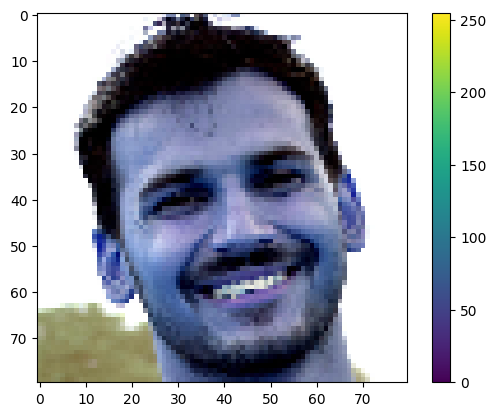

In [ ]:
plt.figure() 
plt.imshow(train_image[0]) 
plt.colorbar() 
plt.grid(False)
plt.show()

In [ ]:
# normalize pixels to range(0,1)
normalized_train_image = train_image / 255.0
normalized_validation_image = validate_image / 255.0
normalized_test_image = test_image / 255.0

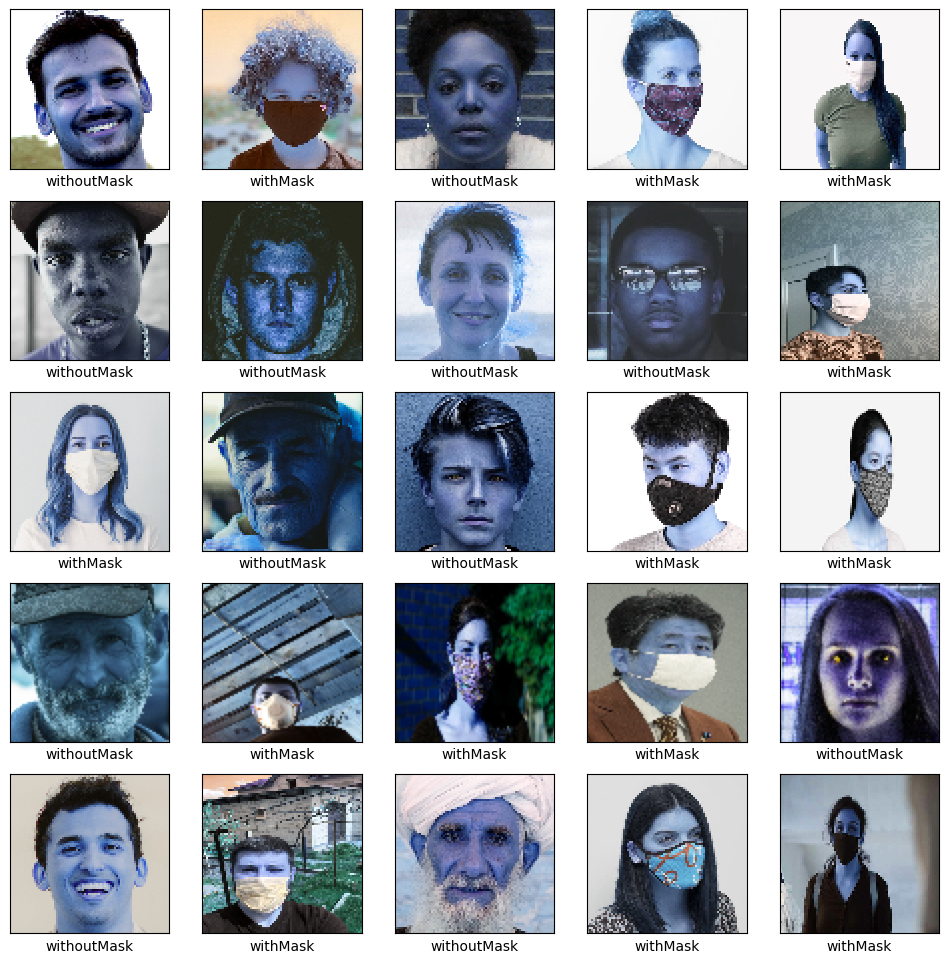

In [ ]:
# check data after normalization
plt.figure(figsize=(12,12)) 
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(normalized_train_image[i], cmap=plt.cm.binary) 
  plt.xlabel(classes[train_label[i]])
plt.show()

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

test_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow(normalized_train_image, train_label, batch_size=10)

# Flow validation images in batches of 10 using val_datagen generator
validation_generator =test_datagen.flow(normalized_validation_image, validate_label, batch_size=10)

# Flow test images in batches of 10 using val_datagen generator
test_generator =test_datagen.flow(normalized_test_image, test_label, batch_size=10)


Baseline Model: DNN

In [ ]:
def create_model():
  model = Sequential() 
  model.add(Flatten(input_shape=(80, 80, 3)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1))
    # compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
  return model
model_simple = create_model()
model_simple.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 19200)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               2457728   
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,457,857
Trainable params: 2,457,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## callback

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]


fit_callbacklist = model_simple.fit(train_generator, epochs=100, 
          batch_size=10, validation_data = validation_generator, 
          callbacks=callbacks_list)

model_simple = keras.models.load_model("checkpoint_path.keras")
model_simple.evaluate(test_generator, verbose=2)


fresh_model_simple = create_model()

Epoch 1/100
25/25 [==============================] - 3s 93ms/step - loss: 3.4703 - accuracy: 0.5854 - val_loss: 0.4634 - val_accuracy: 0.8387
Epoch 2/100
25/25 [==============================] - 2s 72ms/step - loss: 3.7402 - accuracy: 0.5813 - val_loss: 3.2932 - val_accuracy: 0.5806
Epoch 3/100
25/25 [==============================] - 2s 86ms/step - loss: 2.8379 - accuracy: 0.6423 - val_loss: 1.0387 - val_accuracy: 0.7581
Epoch 4/100
25/25 [==============================] - 2s 67ms/step - loss: 1.0367 - accuracy: 0.7561 - val_loss: 0.6653 - val_accuracy: 0.7581
Epoch 5/100
25/25 [==============================] - 1s 48ms/step - loss: 1.3516 - accuracy: 0.6504 - val_loss: 1.4911 - val_accuracy: 0.5968
Epoch 6/100
25/25 [==============================] - 1s 31ms/step - loss: 1.2585 - accuracy: 0.6911 - val_loss: 1.0316 - val_accuracy: 0.7258
Epoch 7/100
25/25 [==============================] - 1s 35ms/step - loss: 1.0681 - accuracy: 0.7317 - val_loss: 0.6440 - val_accuracy: 0.7903
Epoch 

In [ ]:
# checkpoint_dir = "checkpoints"

# try:
#   os.mkdir(checkpoint_dir)
# except:
#   pass

# ## checkpoint the weights when validation accuracy improves
# filename = "weights-best-model.hdf5"
# filepath = os.path.join(checkpoint_dir, filename)
# checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', 
#                              verbose=1, save_best_only=True, 
#                              mode='max')

# history_simple = model_simple.fit(train_generator, epochs=100, batch_size = 10, validation_data=validation_generator, callbacks=[checkpointer])
# fresh_model_simple = create_model()

In [ ]:
fresh_model_simple.load_weights(os.path.join(checkpoint_dir,"weights-best-model.hdf5"))
test_loss_simple, test_acc_simple = fresh_model_simple.evaluate(test_generator, verbose=2)
print('\nTest accuracy for DNN:', test_acc_simple)

14/14 - 0s - loss: 0.4282 - accuracy: 0.8636 - 242ms/epoch - 17ms/step

Test accuracy for DNN: 0.8636363744735718


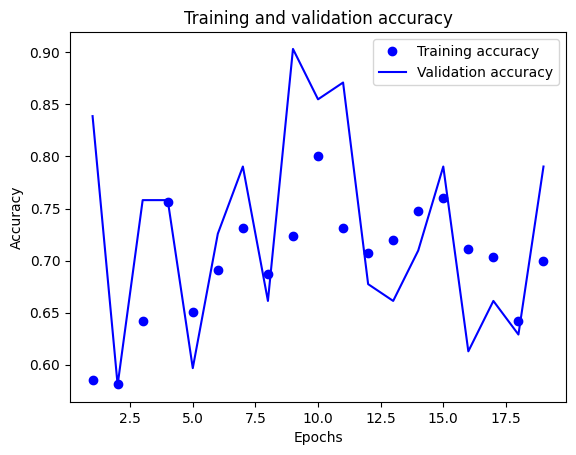

In [ ]:
history_dict = fit_callbacklist.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

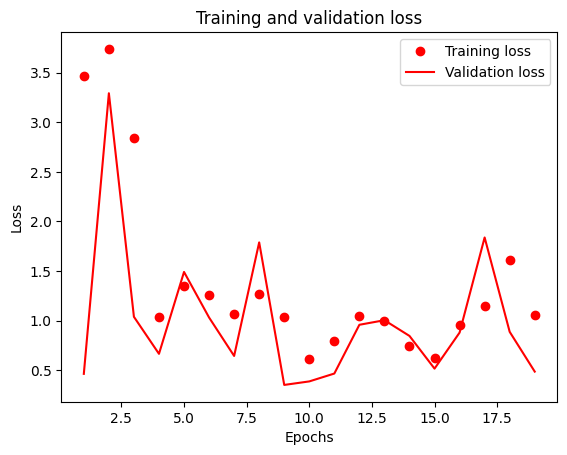

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "ro", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Model 2: CNN

In [ ]:
## Model 2
## CNN with 2 convolution layers, each accompanied with a max pooling layer 

def create_model_cnn():
  model = Sequential()

  # 1st Convolution layer; 
  model.add(Conv2D(32, (3, 3), activation='relu', 
                  padding='same', input_shape=(80, 80, 3)))  ## 1 in input_shape for Gray; 3 for Color
  # 1st Pooling layer
  model.add(MaxPooling2D((2, 2)))
  
  # 2nd Convolution layer
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  # 2st Pooling layer
  model.add(MaxPooling2D((2, 2)))

  # Flattening
  model.add(Flatten())

  # Full_Connection layer (densely connected layer)
  model.add(Dense(64, activation='relu'))

  # output layer
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', 
                loss= 'binary_crossentropy',
                metrics=['accuracy'])
  
  return model

In [ ]:
model_cnn = create_model_cnn()
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_219 (Conv2D)         (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_220 (Conv2D)         (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 25600)             0         
                                                                 
 dense_23 (Dense)            (None, 64)               

In [ ]:
## callback

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]


fit_callbacklist = model_cnn.fit(train_generator, epochs=100, 
          batch_size= 10, validation_data = validation_generator, 
          callbacks=callbacks_list)

model = keras.models.load_model("checkpoint_path.keras")
model.evaluate(test_generator, verbose=2)

Epoch 1/100
25/25 [==============================] - 3s 99ms/step - loss: 0.7337 - accuracy: 0.5325 - val_loss: 0.6700 - val_accuracy: 0.8226
Epoch 2/100
25/25 [==============================] - 2s 98ms/step - loss: 0.5995 - accuracy: 0.7236 - val_loss: 0.4362 - val_accuracy: 0.8871
Epoch 3/100
25/25 [==============================] - 4s 146ms/step - loss: 0.4652 - accuracy: 0.8374 - val_loss: 0.3389 - val_accuracy: 0.8387
Epoch 4/100
25/25 [==============================] - 2s 91ms/step - loss: 0.4043 - accuracy: 0.8089 - val_loss: 0.2619 - val_accuracy: 0.9516
Epoch 5/100
25/25 [==============================] - 2s 89ms/step - loss: 0.4032 - accuracy: 0.8252 - val_loss: 0.3420 - val_accuracy: 0.9032
Epoch 6/100
25/25 [==============================] - 2s 95ms/step - loss: 0.3588 - accuracy: 0.8577 - val_loss: 0.3963 - val_accuracy: 0.8710
Epoch 7/100
25/25 [==============================] - 2s 90ms/step - loss: 0.3443 - accuracy: 0.8618 - val_loss: 0.3710 - val_accuracy: 0.9194
Epoch

[0.3161223828792572, 0.8863636255264282]

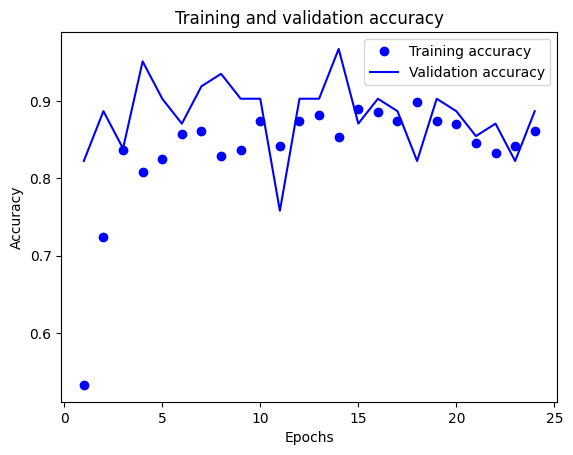

In [ ]:
history_dict = fit_callbacklist.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

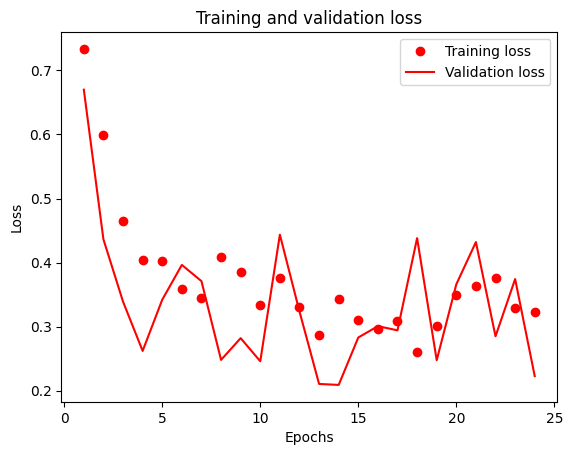

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "ro", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Pretrained Model

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from mtcnn import MTCNN

def pretrained():

  # Load the pre-trained MTCNN model
  detector = MTCNN()

  # Load the Inception ResNet V2 model
  base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False, weights='imagenet', input_shape=(80, 80, 3)
  )

  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add extra layers
  x = Flatten()(base_model.output)
  x = Dense(64, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x)

  # Define the model
  model = Model(inputs=base_model.input, outputs=output)

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model


In [ ]:
model_pretrained = pretrained()
model_pretrained.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_233 (Conv2D)            (None, 39, 39, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 39, 39, 32)  96          ['conv2d_233[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 39, 39, 32)   0           ['batch_normalization_203[0

In [ ]:
## callback

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]


fit_callbacklist = model_pretrained.fit(train_generator, epochs=100, 
          batch_size=10, validation_data = validation_generator, 
          callbacks=callbacks_list)

model_pretrained = keras.models.load_model("checkpoint_path.keras")
model_pretrained.evaluate(test_generator, verbose=2)

Epoch 1/100
25/25 [==============================] - 13s 309ms/step - loss: 0.1403 - accuracy: 0.9512 - val_loss: 0.4602 - val_accuracy: 0.8548
Epoch 2/100
25/25 [==============================] - 7s 290ms/step - loss: 0.1333 - accuracy: 0.9431 - val_loss: 0.2499 - val_accuracy: 0.8710
Epoch 3/100
25/25 [==============================] - 5s 205ms/step - loss: 0.1550 - accuracy: 0.9268 - val_loss: 0.5063 - val_accuracy: 0.8226
Epoch 4/100
25/25 [==============================] - 7s 277ms/step - loss: 0.2455 - accuracy: 0.9228 - val_loss: 0.3815 - val_accuracy: 0.9032
Epoch 5/100
25/25 [==============================] - 9s 365ms/step - loss: 0.1869 - accuracy: 0.9350 - val_loss: 0.3812 - val_accuracy: 0.9194
Epoch 6/100
25/25 [==============================] - 5s 188ms/step - loss: 0.1970 - accuracy: 0.9228 - val_loss: 0.3937 - val_accuracy: 0.8548
Epoch 7/100
25/25 [==============================] - 5s 205ms/step - loss: 0.1024 - accuracy: 0.9634 - val_loss: 0.4411 - val_accuracy: 0.838

[0.18220500648021698, 0.9318181872367859]

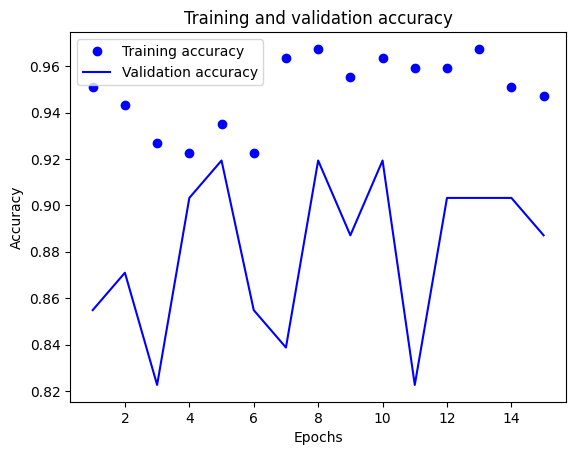

In [ ]:
history_dict = fit_callbacklist.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

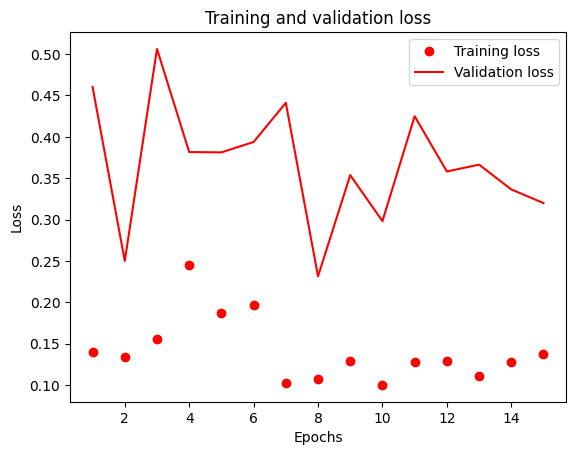

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "ro", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()